# In this notebook we have:

- Integrity checks (to check the data and distributions)
- Evaluation of the experiment

# Integrity checks: Check the data before making conclusions

- This is a second notebook (after ***pre_experiment***). Here we want to check different distributions and slices in our dataset. And then evaluate our experiment

- Changes in time, distributions of metrics and different segments

- The purpose of this analysis is to ensure that there are no problems with the data

In [1]:
import sys
import os
root_path = os.path.realpath('..')
sys.path.insert(0, root_path)

from tw_experimentation.utils import ExperimentDataset
from tw_experimentation.data_generation import RevenueConversion
from tw_experimentation.widgetizer import FrequentistEvaluation, SegmentationInterface, Segmentation
from tw_experimentation.statistical_tests import cuped

import numpy as np
import pickle

import plotly.io as pio
pio.renderers.default = "png"

import warnings
warnings.filterwarnings('ignore')
from tw_experimentation.checker import Monitoring, SegmentMonitoring, SequentialTest
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Loading data

- Here we use synthetic dataset, please use your dataset instead of ***df_abn***

In [2]:
# generating synthetic data for ease of exposition
# here you can replace the df_abn with your own data

np.random.seed(40)

rc = RevenueConversion()

df_abn = rc.generate_data_abn_test(
    n=10000,
    n_treatments = 2,
    baseline_conversion = .4,
    treatment_effect_conversion=.02,
    baseline_mean_revenue = 6,
    sigma_revenue = 1,
    treatment_effect_revenue = .05
)

df_abn['currency'] = np.random.choice(['GBP', 'EUR', 'USD'], size=len(df_abn))
df_abn['country_of_origin'] = np.random.choice(['UK', 'US', 'USD'], size=len(df_abn))
df_abn['segment_1'] = np.random.choice(['New', 'Old'], size=(len(df_abn), 1))
df_abn['segment_2'] = np.random.choice(['Active', 'Rare', 'Usual'], size=(len(df_abn), 1))
df_abn['segment_3'] = np.random.choice(['10+ transfers', '10- transfers'], size=(len(df_abn), 1))

- `T`: Column with variants for your experiment
- `conversion`: Example of binary metric
- `revenue`: Example of continious metric
- `trigger_dates`: An example of a timestamp when a variant was assigned to a user
- `currency`: Example of a column for checks

### Then we should specify our target variables, for example conversion and revenue
- And add information to the ***metrics*** variable: are they binary or continious
- After that we will get our data in the **ExperimentDataset** for creation data for the analysis

### Data model definition
- Please specify your columns with variants, timestamp, main metrics


***Variants should be in the format 0,1,2,.. are assumed where 0 is the control group and 1[,2,...] are the treatment groups.***

- If this cell does not work in VScode, try to restart the app

We now define all the relevant information about the dataset that will be used in the experiment analysis. 
You should specify
- `data`: Name of the pandas.DataFrame
- `variant`: column name of the variant assignment (control vs treatment). Note that the column must consist of value of values 0,1,2,... where 0 stands for control group, 1 for treatment and 2,3,...for further treatment groups
- `targets`: List with names of columns with key outcome metrics
- `date`: If available, name of column with timestamps
- `pre_experiment_cols`: Name of columns with pre-experimental data. This can be used for an improvement sensitivity analysis with CUPED
- `n_variants`: Number of variants (control + number of treatments). For instance, if there is one control and one treatment, n_variants should be 2. Defaults to 2.

In the preprocessing step, outliers are removed by default (`outlier_removal=True`). If you would like to turn off outlier removal, set
`outlier_removal=False`.

Change the following entries accordingly and run the cell.

In [4]:
ed = ExperimentDataset(
    data=df_abn,
    variant="T",
    targets=['conversion', 'revenue'],
    date='trigger_dates',
    pre_experiment_cols=['pre_exp_revenue'],
    n_variants=2,
)
ed.preprocess_dataset(remove_outliers=True)

### So we finally transformed our data for checks

In [5]:
experiment_dataset = ed

In [6]:
with open('../data/experiment_dataset.pickle', 'wb') as f:
    pickle.dump(experiment_dataset, f)

More generally, you can provide your data as follows

In [7]:
# targets = [ # Specify the name of the columns with metrics for analysis
# 'conversion',
# 'revenue'
# ]

# metrics = [ # Specify metrics types, or leave empty to infer automatically
#     'binary',
#     'continuous'
#     ]


# ed = ExperimentDataset(
#     data=df_abn, # Your dataset
#     variant='T', # Column with groups
#     targets=targets, # Specify the name of the columns with metrics for analysis
#     date='trigger_dates',
#     metric_types=dict(zip(targets, metrics)), # Specify metrics types
#     n_variants=2 # The number of groups
# )
# ed.preprocess_dataset()
# experiment_dataset = ed

### Monitoring 

In [8]:
monitor = Monitoring(ed)
monitor_results = monitor.create_tables_and_plots()

You can now display the results from the Monitoring:
- `sample_size_table`: Sample sizes
- `fig_sample_size_pie`: Pie chart with sample sizes
- `fig_dynamic_sample_size`: Sample size evolution
- `fig_target_metric_distribution`: Figures with target metric distributions (one figure per target)
- `fig_target_cdf`: Empirical cumulative distribution per target (one figure per target)
  
  They can be seen as follows:

In [9]:
monitor_results.sample_size_table

,Sample size
Variant 0 (control),3239
Variant 1 (treatment),3303
Variant 2 (treatment),3358
Total sample size,9900


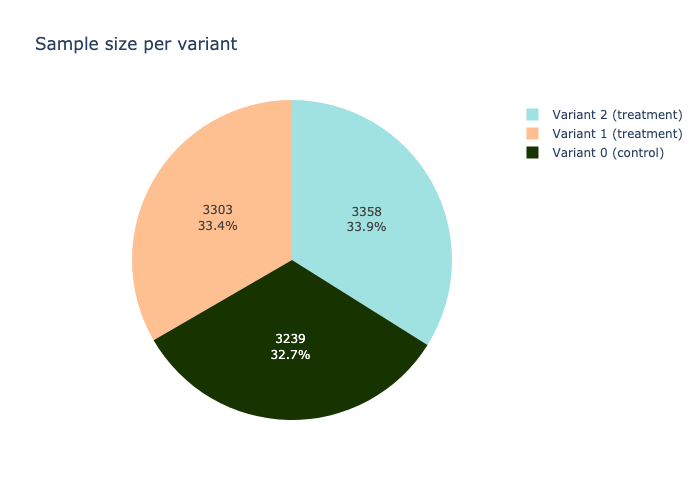

In [10]:
monitor_results.fig_sample_size_pie

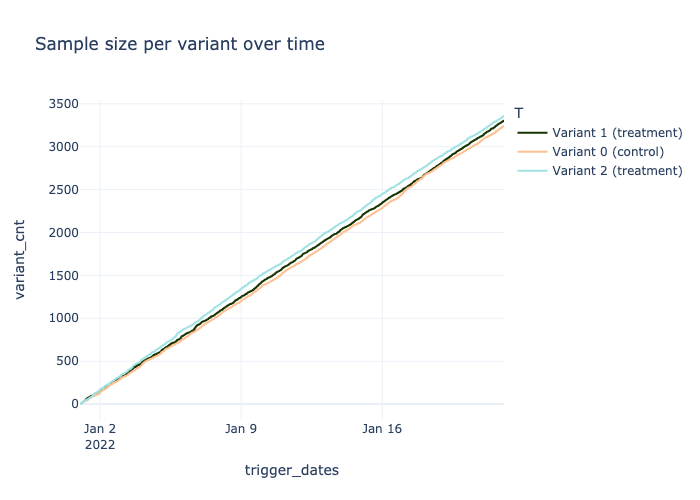

In [11]:
monitor_results.fig_dynamic_sample_size

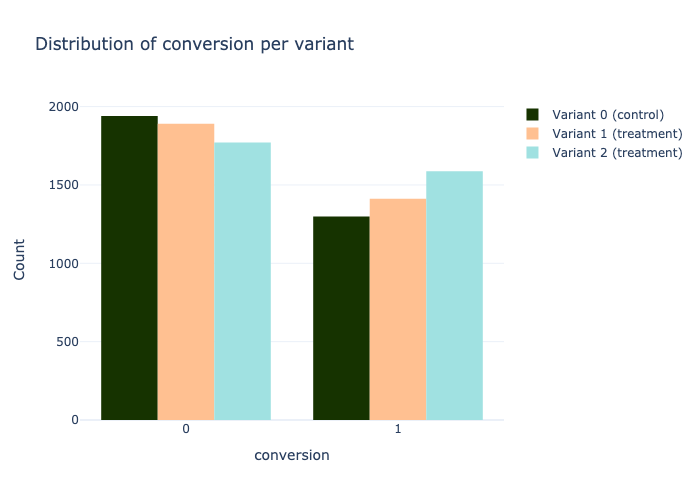

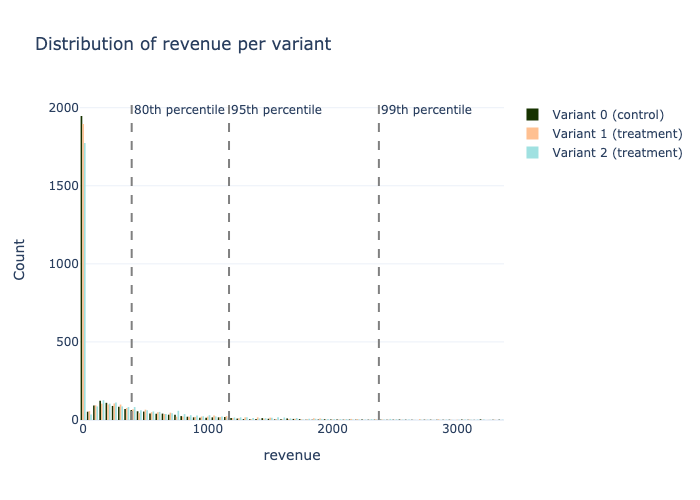

In [12]:
for target in ed.targets:
    monitor_results.fig_target_metric_distribution[target].show()

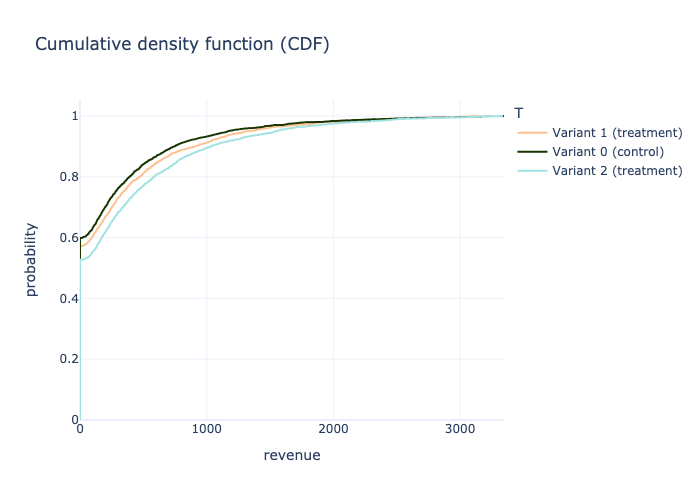

In [13]:
for target in monitor_results.fig_target_cdf.keys():
    monitor_results.fig_target_cdf[target].show()

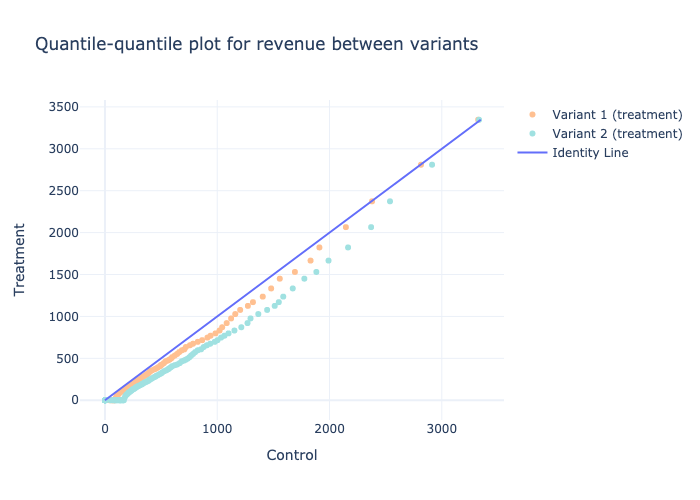

In [14]:
for target in monitor_results.fig_target_qq_variants.keys():
    monitor_results.fig_target_qq_variants[target].show()

### Segments monitoring

- After specifying main metrics we can check specific segment/segments 

In [15]:
# choose segments to monitor
segments = ['currency', 'segment_1', 'segment_2']

segment_monitor = SegmentMonitoring(ed, segments)
segment_monitor_results = segment_monitor.create_tables_and_plots()

You can now display the results from the Segment Monitoring:
- `table_chi_squared_test`: Chi-squared test of independence between variants and segments
- `figs_chi_squared_heatmaps`: Heatmaps illustrating the chi-squared test statistic contributions
- `figs_segment_sample_size`: Sample size per segment
- `figs_segment_histograms`: Distribution of metric per segment
  
  They can be seen as follows:

In [16]:
segment_monitor_results.table_chi_squared_test

,segment,p-value,is significant at the 0.05 level,decision
0,currency,0.057638,False,There is sufficient indication that there is n...
1,segment_1,0.492696,False,There is sufficient indication that there is n...
2,segment_2,0.092836,False,There is sufficient indication that there is n...


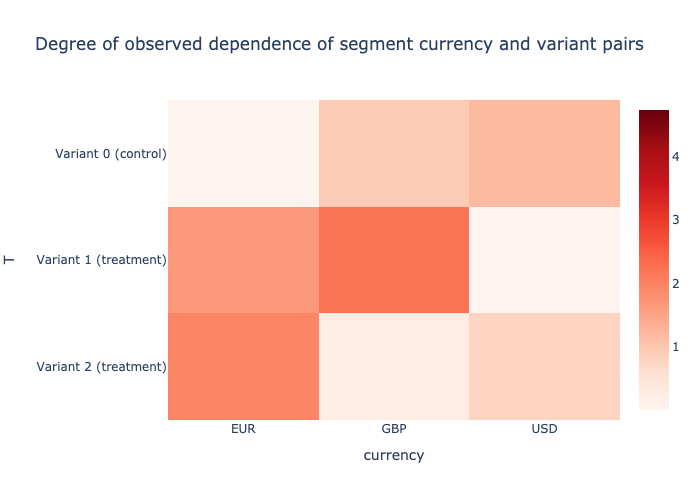

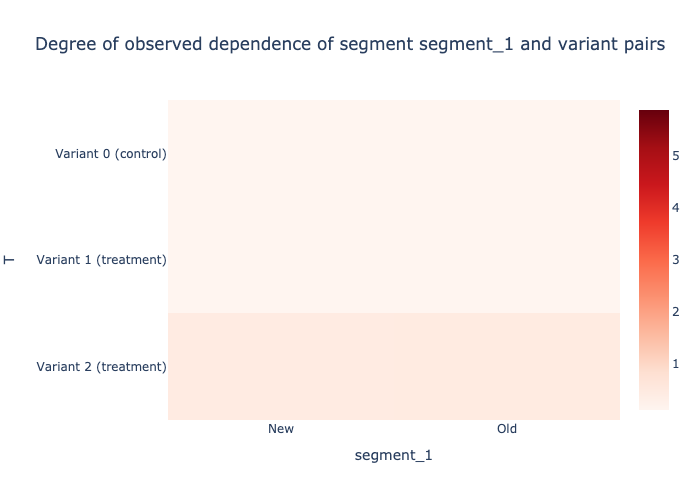

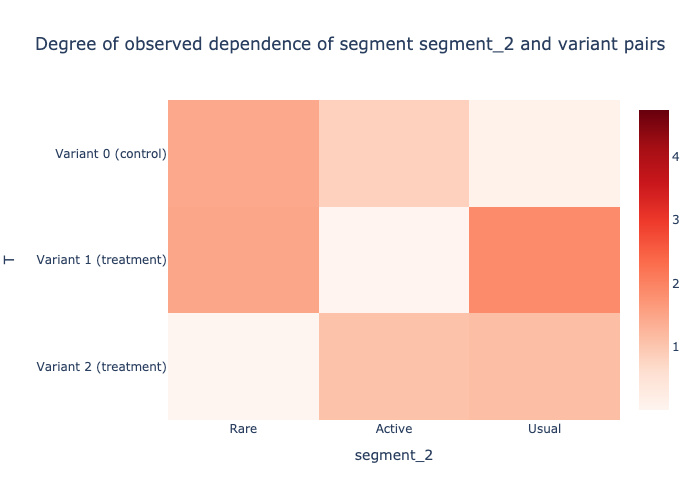

In [17]:
for segment in segments:
    segment_monitor_results.figs_chi_squared_heatmaps[segment].show()

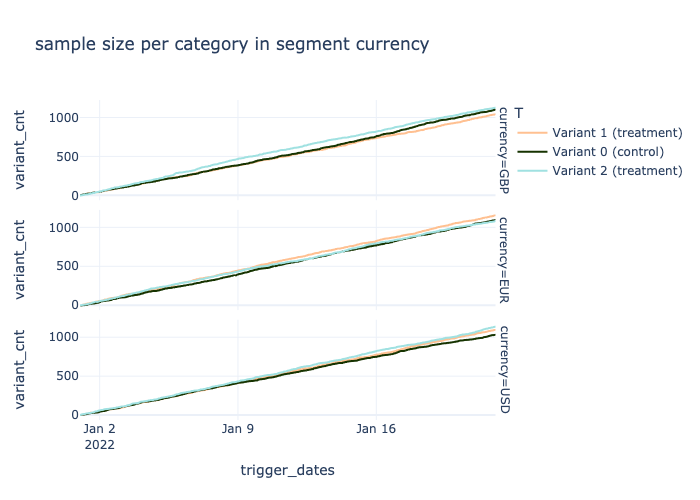

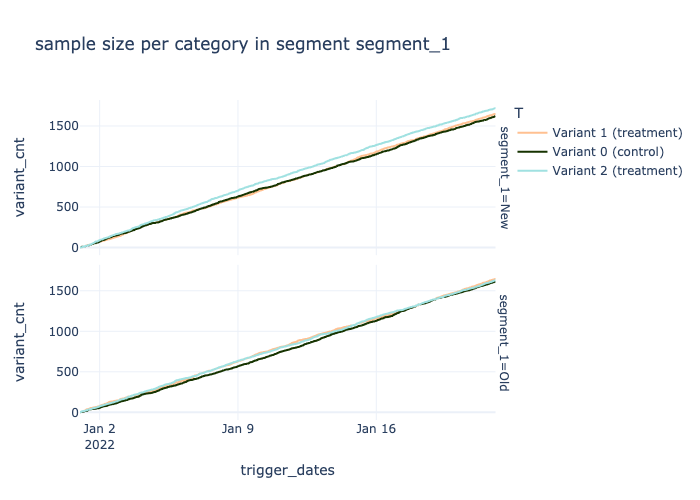

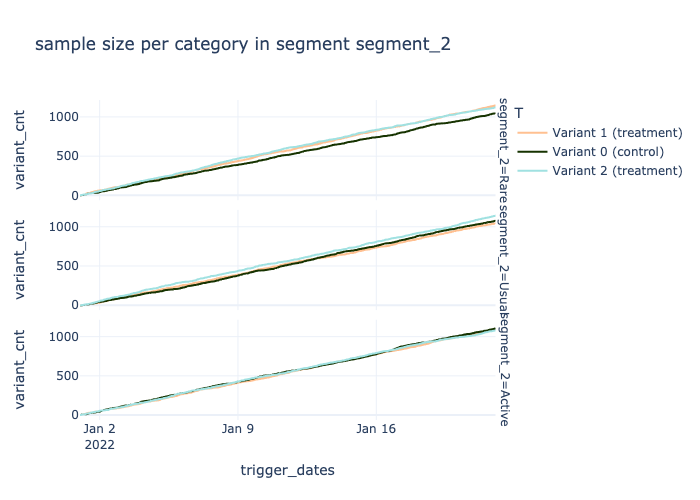

In [18]:
for segment in segments:
    segment_monitor_results.figs_segment_sample_size[segment].show()

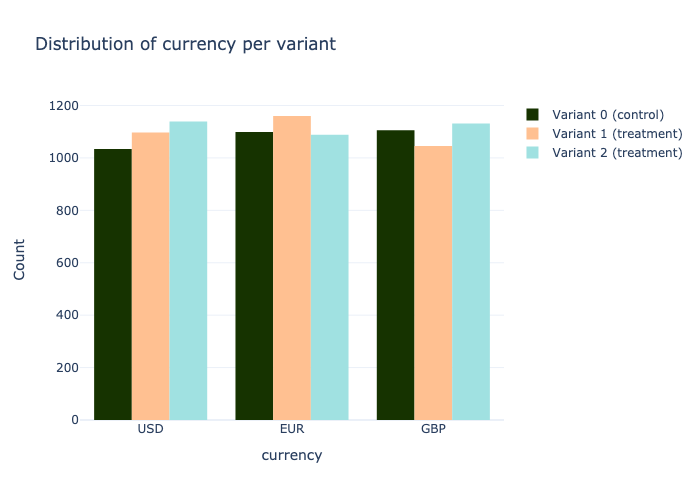

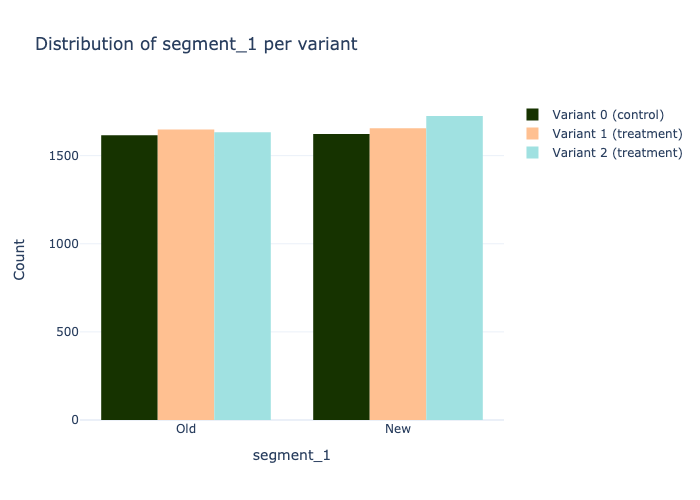

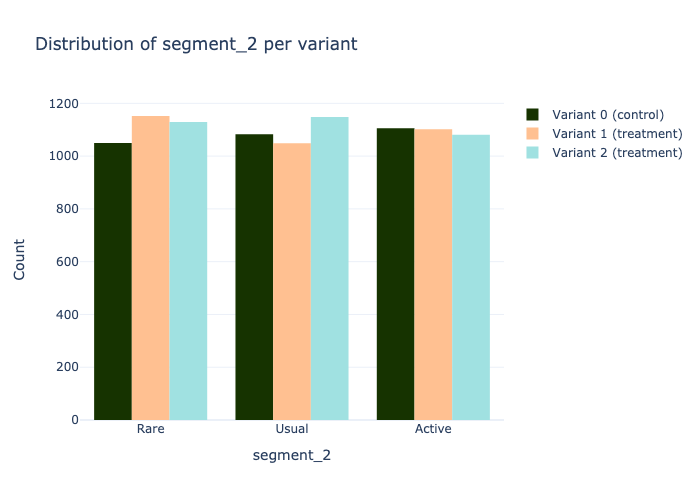

In [19]:
for segment in segments:
    segment_monitor_results.figs_segment_histograms[segment].show()

## Monitoring treatment effect / Sequential testing over time
- (If you have timestamp)

- Here we can check metrics in time, averages and if there were any changes we can see it in the p-value

Instead of static tests monitoring, you can also run a sequential test which potentially allows you to stop the test early (if the p-value in the following plot is below a predefined threshold such as alpha=.05).

Run the following line of code to see 
 - left column: average of each outcome over time (for both treatments and control)
 - center column: treatment effect with confidence interval over time for each treatment group
 - right column: dynamic p-value based on a sequential hypothesis test for each treatment

- `Metric average`: Changes in metrics over time
- `Treatment Effect`: Changes in effect over time
- `p-Value`: Changes in p-value over time

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


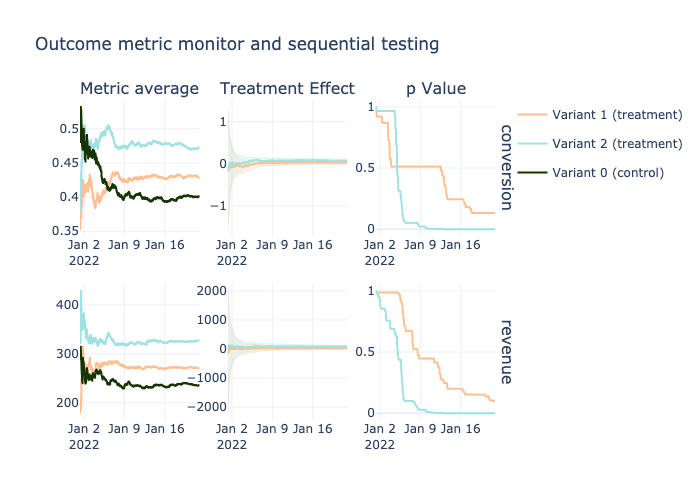

In [20]:
sequential_test = SequentialTest(ed)
sequential_test_results = sequential_test.sequential_test_results()
fig = sequential_test.fig_sequential_test()
fig.show()

###  What's next? 
- After checking specific segments, we can run statistical tests in ***evaluation***

# Evaluation of the A/B experiment

- If we have already designed experiment design, and run integrity checks in ***pre_experiment*** and ***integrity_checks***, we can run statistical tests for statistical evaluation.

- In this notebook we want to check if there is a significant treatment effect in the experiment, so we run statistical tests: Proportion Z-Test for binary outcomes, T-Test for continuous outcomes for our groups

- In this section you can test hypotheses about your groups
- And check if you have a statistically significant result by getting the p-value

In case you have multiple treatment variants, you will have the option to perform a multi-test correction on the p-values (current implementation: Bonferroni method. This is subject to change in the future). 

## Standard T-test

In [21]:
evaluation = FrequentistEvaluation(experiment_dataset)
evaluation.start()

HTML(value='<h2><b>Test Evaluation</b></h2>')

interactive(children=(Dropdown(description='multi-test correction:', index=1, options=('No', 'Yes'), style=Des…

### How can I interpret the results?

- We compare each treatment variant with the control group
- The statistic of interest is the difference in means for every specified metric.
- This yields estimated treatment effects and p-value for them
- By convention, if p-value < 0.05 the result is regarded significant
- We also provide confidence intervals for metrics


## T-test with Power/Sensitivity Improvement via CUPED

In [22]:
cuped(experiment_dataset, has_correction='Yes', alpha=0.05)

[ 4.36327660e-01 -3.34548249e-06]
[ 4.36327660e-01 -3.34548249e-06]
[2.72669251e+02 7.85634769e-03]
[2.72669251e+02 7.85634769e-03]


,,Estimated_Effect_absolute,CI_lower,CI_upper,p_value,is_significant
Variant,Outcome,,,,,
1,conversion,-0.010008,-0.033693,0.013676,3.435165e-01,False
2,conversion,0.058139,0.034586,0.081692,3.216530e-08,True
1,revenue,-11.785234,-36.176226,12.605758,2.787614e-01,False
2,revenue,74.108518,49.872644,98.344393,7.566676e-12,True


### How can I interpret the results?
- The above presents the result of the T-test after the power/sensitivity method has been applied
- The conclusions which can be drawn are the same as for the vanilla T-tests

## Segmentation with Wise Pizza

- In this section you can find unusual segments in terms of the difference between the control and test groups
- Please provide segments which you want to analyse, metric to analyse and number of observations

In [23]:
#change to your own segment names
segments = ['segment_1', 'segment_2', 'segment_3', 'currency']

# change to treatment number of interest
treatment = 1

**wise_pizza_frequentist**: Find segments whose average is most different from the global one

- `segments`: List of discrete dimensions to find slices
- `target`: Metric to analyse
- `treatment`: If you have different test groups, specify group here, for example treatment=1 means we compare with first treatment group
- `min_segments`: Minimum number of segments to find
- `max_segments`: Maximum number of segments to find, defaults to min_segments
- `min_depth`: Minimum number of dimension to constrain in segment definition
- `max_depth`: Maximum number of dimension to constrain in segment definition
    
 
- Use `.plot()` to see the plot after fitting:
    - `plot_is_static`: static (True) or dynamic (False) plotly result
        - `True`: to get static plots (Doesn't work on all platforms yet)
        - `False`: to get dynamic plots
    - `width`: to change the width of the plot
    - `height`: to change the height of the plot
    
    
- Use `.segments` to see the values after fitting

*Warning*: The p-values are currently not corrected for multiple comparisons. However, Wise-Pizza identifies segments as interesting only if the treatment effect is sufficiently high compared to the segment sample size so this selection is a first approximation of avoiding p-value inflation in segmentation analysis.

In [24]:
segmentation = Segmentation(ed=experiment_dataset)
wise_pizza_segmentation = segmentation.wise_pizza_frequentist(
    target='revenue',
    treatment=treatment,
    segments=segments,
    max_depth=2, # customize to own preference
    min_segments=3 # customize to own preference
    )

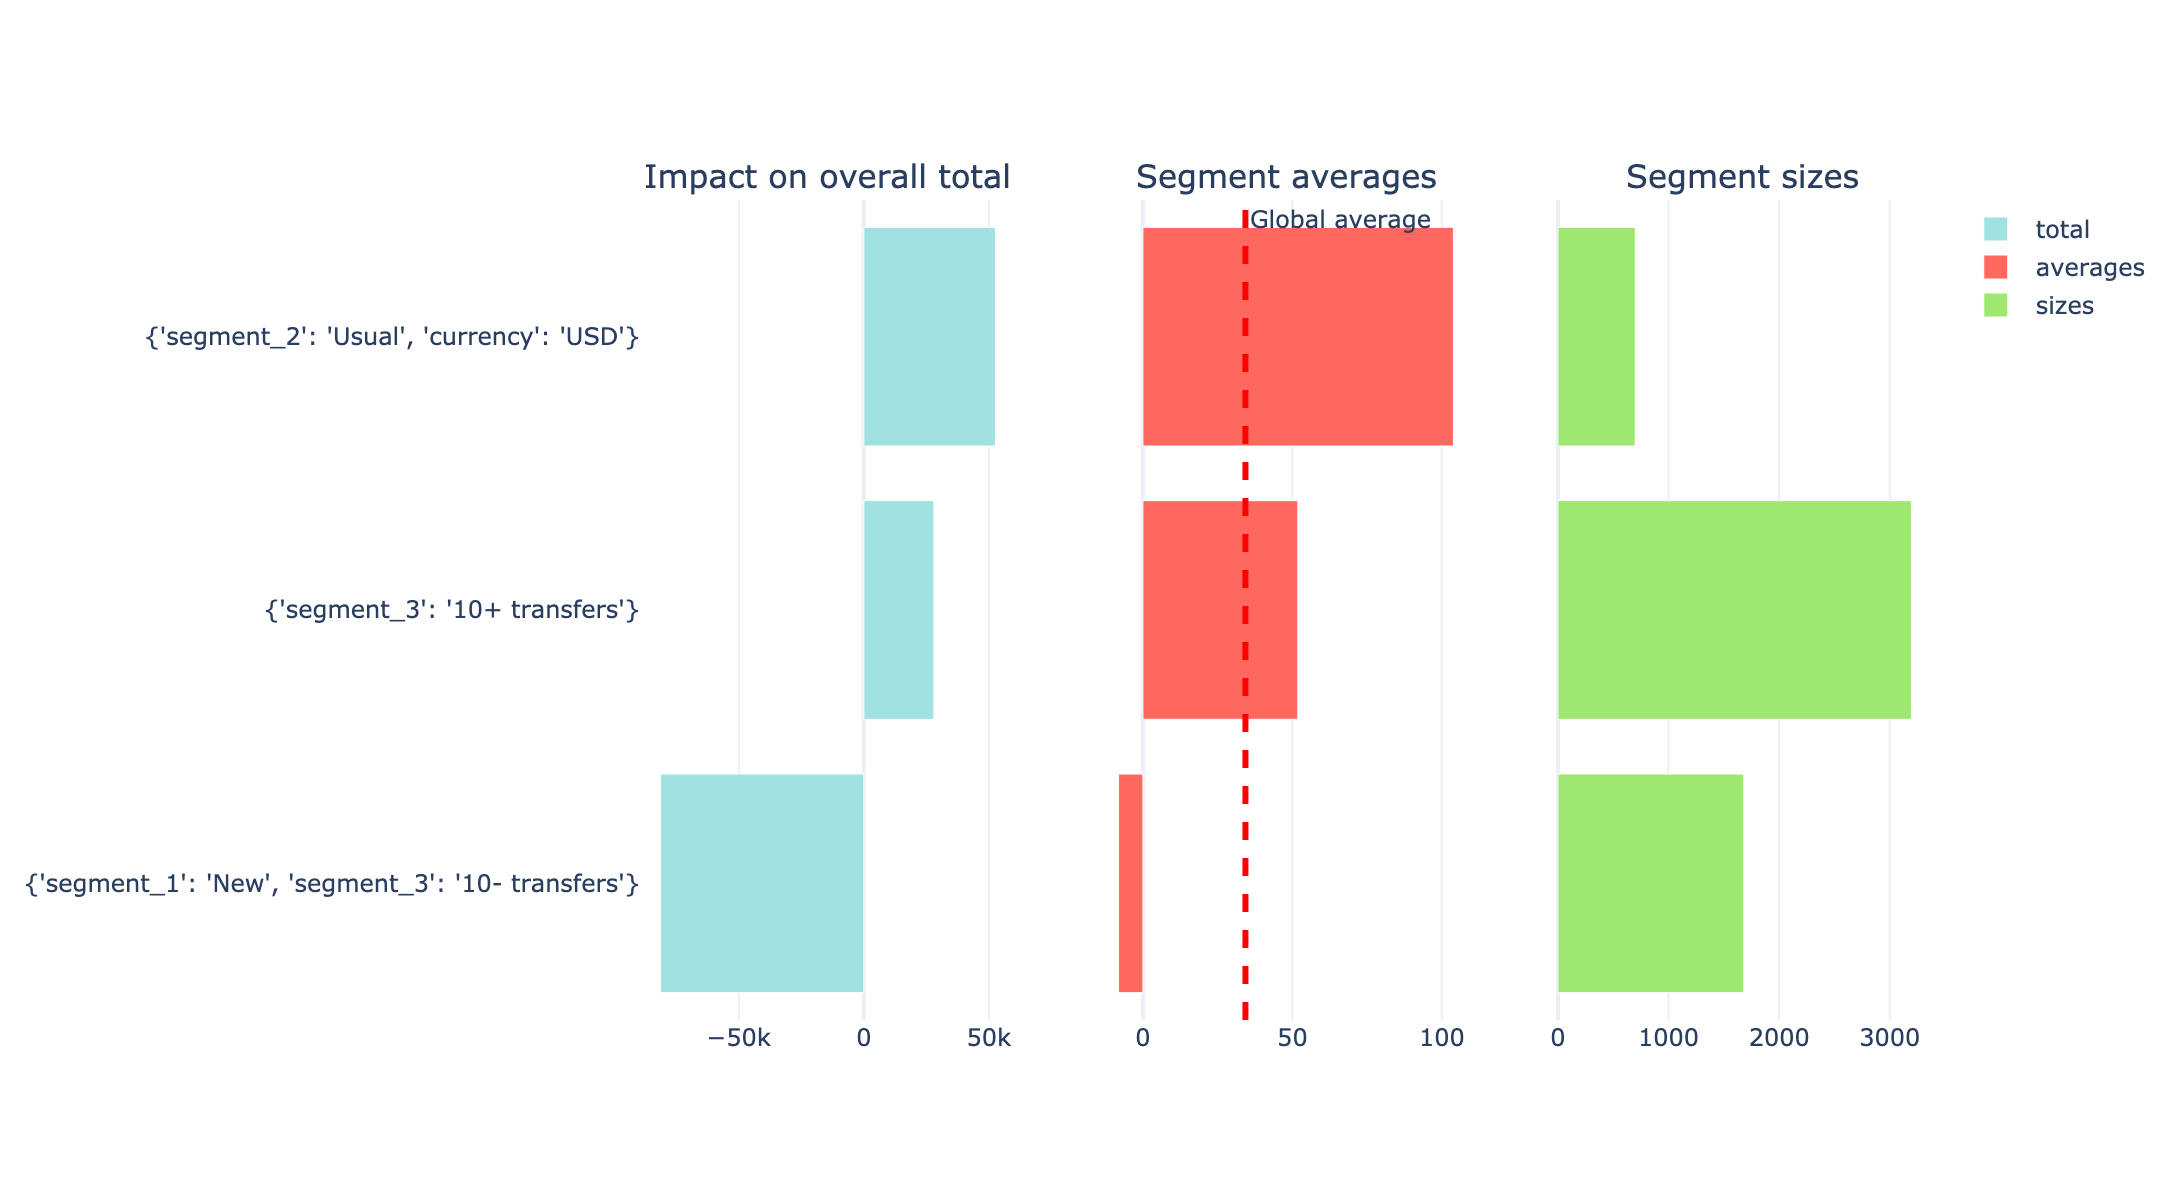

In [25]:
slice_finder = segmentation.get_sf()
slice_finder.plot(width=1000, plot_is_static=True)

# How can I interpret the results?

- We are trying to find unusual segments in terms of the averages (***to highlight the segments contributing the most to the difference between test and control***)
- Impact (Blue) is the model coefficient * size, if it is bigger than zero, than segment average is bigger than the global one (global difference in metric between test and control)
- Simple segment averages (Red) - average for specific segment
- Segment Sizes (Green) - number if observations in the segment


## Evaluation for segments
- In this section you can get p-value and statistical resuls for the selected segment

If this cell does not work in VScode, try to restart the app

In [26]:
segmentation_interface = SegmentationInterface(experiment_dataset)

HTML(value='<h2><b>Evaluation: Segmentation</b></h2>')

interactive(children=(Dropdown(description='Segment', options=('country_of_origin', 'pre_exp_revenue', 'segmen…

# How can I interpret the results?

- For each variant we compare it with the control group

- Here we have mean values for every specified metric.
- Then we have estimated effects and p-value for them
- By default if p-value < 0.05 the result is significant
- And then we have confidence intervals for metrics
